<a href="https://colab.research.google.com/github/fabribara/DataScience/blob/main/ETL_Assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries and components that will be needed

In [49]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

Copy Data
1. Establish Connection : Build connection string and column mapping
2. Copy data : Ingest Data with the given parameters and copy them in a data set or data frame in this case

In [50]:
seriesTuples =(
"UNRATE",
"BAMLCC0A0CMTRIV",
"BAMLHYH0A0HYM2TRIV",
"NASDAQ100",
"SP500",
"WILLMICROCAPPR",
"DFF",
"CPALTT01USM659N",
"VIXCLS",
)
seriesNames = (
"Unemployment Rate",
"US Corporate Bond Index",
"US High Yield Bond Index",
"NASDAQ100 index",
"S&P 500 Index",
"Wilshire Microcap Index",
"Federal Funds Effective Rate",
"Consumer Price Index: Total All Items for the United States",
"CBOE VIX",
)
entityDict = {}

for i in range(len(seriesTuples)):
  connString = "https://api.stlouisfed.org/fred/series/observations?series_id="+seriesTuples[i]+"&file_type=json&observation_start=2000-01-01&api_key=767fc6b25ba04e098a56a3fa1806820d"
  observationsDf = pd.json_normalize(pd.read_json(connString)['observations'])
  observationsDf['realtime_start']=observationsDf['realtime_start'].astype(np.datetime64)
  observationsDf['realtime_end']=observationsDf['realtime_end'].astype(np.datetime64)
  observationsDf['date']=observationsDf['date'].astype(np.datetime64)
  observationsDf=observationsDf.replace({'value': r'^\.$'}, {'value': np.nan}, regex=True)
  observationsDf['value']=observationsDf['value'].astype(np.number)
  observationsDf=observationsDf.set_index(observationsDf['date'])
  entityDict[seriesTuples[i]]=(observationsDf.copy())

Data Profiling
1. Review types : all types cames ad objects so conversions have to be done
2. Numerical values analysis : numeric values profiling time series analysis helped
2. Catogorical values frequencies : no categorical variables
3. Identify relationships between entitys to model : all indexes are related by time

Unemployment Rate
            value
count  273.000000
mean     5.882051
std      1.956101
min      3.500000
25%      4.400000
50%      5.400000
75%      6.700000
max     14.700000
US Corporate Bond Index
             value
count  5958.000000
mean   2164.787611
std     739.184376
min     984.250000
25%    1524.577500
50%    2140.560000
75%    2799.200000
max    3587.150000
US High Yield Bond Index
             value
count  5958.000000
mean    845.419489
std     383.688114
min     321.240000
25%     500.382500
50%     813.320000
75%    1191.915000
max    1579.580000
NASDAQ100 index
              value
count   5743.000000
mean    4219.471899
std     3701.617452
min      804.640000
25%     1659.775000
50%     2618.040000
75%     5301.515000
max    16573.340000
S&P 500 Index
             value
count  2517.000000
mean   2700.419873
std     875.462131
min    1353.330000
25%    2033.660000
50%    2526.900000
75%    3191.140000
max    4796.560000
Wilshire Microcap Index
              value
coun

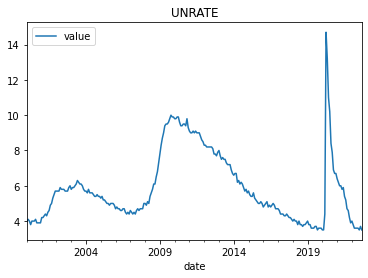

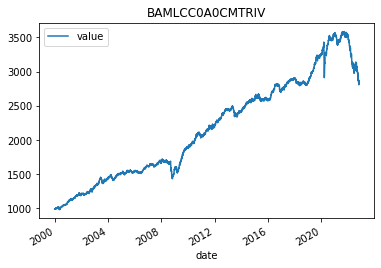

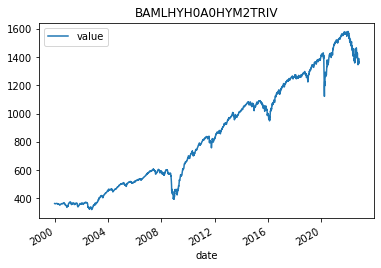

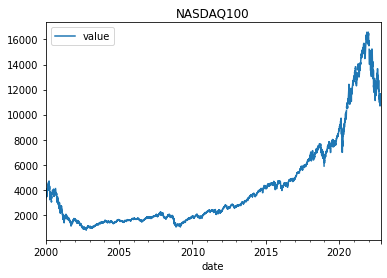

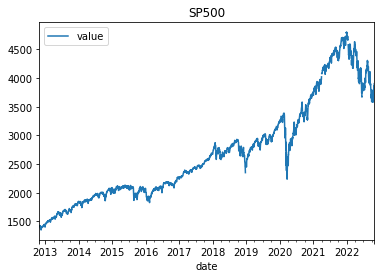

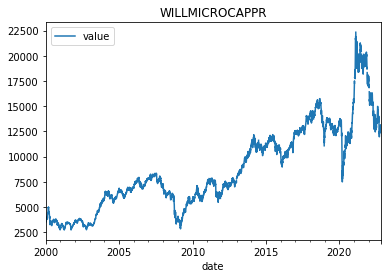

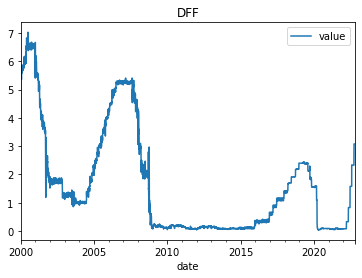

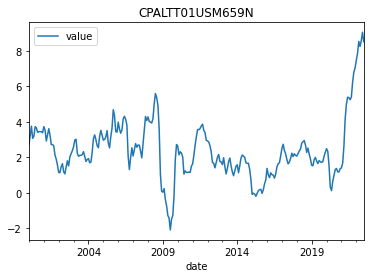

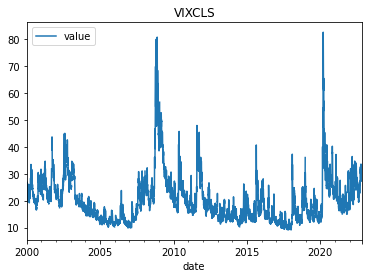

In [51]:
entityDict["BAMLCC0A0CMTRIV"].dtypes

entityDict["BAMLCC0A0CMTRIV"].head()
for i in range(len(seriesTuples)):
  print(seriesNames[i])
  print(entityDict[seriesTuples[i]].describe())
  entityDict[seriesTuples[i]].plot('date','value',title =seriesTuples[i])
# did some adjustments in the copy section
#  observationsDf['realtime_start']=observationsDf['realtime_start'].astype(np.datetime64)
#  observationsDf['realtime_end']=observationsDf['realtime_end'].astype(np.datetime64)
#  observationsDf['date']=observationsDf['date'].astype(np.datetime64)
#  observationsDf=observationsDf.replace({'value': r'^\.$'}, {'value': np.nan}, regex=True)
#  observationsDf['value']=observationsDf['value'].astype(float)

Start to merge the indexes in one final data set
1. Rename the value column with the name of the index

In [52]:


for i in range(len(seriesTuples)):
  entityDict[seriesTuples[i]].rename(columns={'value': seriesNames[i]}, inplace=True)
  print(entityDict[seriesTuples[i]].head())
 
 

           realtime_start realtime_end       date  Unemployment Rate
date                                                                
2000-01-01     2022-10-30   2022-10-30 2000-01-01                4.0
2000-02-01     2022-10-30   2022-10-30 2000-02-01                4.1
2000-03-01     2022-10-30   2022-10-30 2000-03-01                4.0
2000-04-01     2022-10-30   2022-10-30 2000-04-01                3.8
2000-05-01     2022-10-30   2022-10-30 2000-05-01                4.0
           realtime_start realtime_end       date  US Corporate Bond Index
date                                                                      
2000-01-03     2022-10-30   2022-10-30 2000-01-03                   991.58
2000-01-04     2022-10-30   2022-10-30 2000-01-04                   995.74
2000-01-05     2022-10-30   2022-10-30 2000-01-05                   990.59
2000-01-06     2022-10-30   2022-10-30 2000-01-06                   993.67
2000-01-07     2022-10-30   2022-10-30 2000-01-07                  

Merge all the indexes in one data set
1. Implement a union all of all indexes and group them by date, threat missing values as null or blank values

In [53]:
indexList = list()
for i in range(len(seriesTuples)):
  indexList.append(entityDict[seriesTuples[i]][[seriesNames[i]]])

finalDF=pd.concat(indexList).groupby(by=["date"]).sum()
finalDF.replace(0, np.nan, inplace=True)


Once the result is consolidated in one data set verify the results by implementing "Consitency Checkssums", using aggregated funcions such as max, min and counts

In [54]:
diffSums=0
diffMeans=0

for i in range(len(seriesTuples)):  
  diffSums+= ((entityDict[seriesTuples[i]][[seriesNames[i]]].sum().sum())-finalDF[seriesNames[i]].sum())
  diffMeans+= ((entityDict[seriesTuples[i]][[seriesNames[i]]].replace(0, np.nan).mean().mean())-finalDF[seriesNames[i]].mean())
  nanCount+= ((entityDict[seriesTuples[i]][[seriesNames[i]]].replace(0, np.nan).count().count())-finalDF[seriesNames[i]].count())
  print((entityDict[seriesTuples[i]][[seriesNames[i]]].replace(0, np.nan).count()))
  print(finalDF[seriesNames[i]].count())

for i in range(len(seriesTuples)):  
  print((entityDict[seriesTuples[i]][[seriesNames[i]]].replace(0, np.nan).sum()))
  print(finalDF[seriesNames[i]].sum())

for i in range(len(seriesTuples)):  
  print((entityDict[seriesTuples[i]][[seriesNames[i]]].replace(0, np.nan).mean()))
  print(finalDF[seriesNames[i]].mean())

Unemployment Rate    273
dtype: int64
273
US Corporate Bond Index    5958
dtype: int64
5958
US High Yield Bond Index    5958
dtype: int64
5958
NASDAQ100 index    5743
dtype: int64
5743
S&P 500 Index    2517
dtype: int64
2517
Wilshire Microcap Index    5744
dtype: int64
5744
Federal Funds Effective Rate    8336
dtype: int64
8336
Consumer Price Index: Total All Items for the United States    271
dtype: int64
271
CBOE VIX    5748
dtype: int64
5748
Unemployment Rate    1605.8
dtype: float64
1605.8
US Corporate Bond Index    1.289780e+07
dtype: float64
12897804.589
US High Yield Bond Index    5037009.317
dtype: float64
5037009.317
NASDAQ100 index    2.423243e+07
dtype: float64
24232427.118
S&P 500 Index    6796956.82
dtype: float64
6796956.819999999
Wilshire Microcap Index    50093095.62
dtype: float64
50093095.62
Federal Funds Effective Rate    13562.26
dtype: float64
13562.26
Consumer Price Index: Total All Items for the United States    650.928314
dtype: float64
650.9283136619858
CBOE VI

Consistency chechs passed, some irrelevant differences where found, this is related to the architecture of the CPU and the use of float data types

In [55]:
print(diffSums)
print(diffMeans)


8.367123882635497e-09
4.53859172466764e-13
-162156


Save the results to a csv file and plot the results

In [59]:
finalDF.to_csv("result.csv")

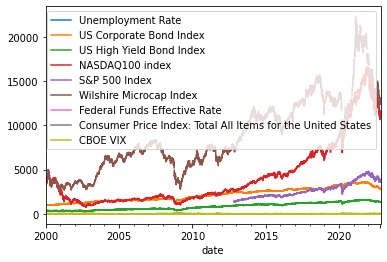

In [57]:
finalDF.plot()
